## Setup

In [1]:
import warnings
warnings.filterwarnings("ignore")

from __future__ import division

import numpy as np
import os
from glob import glob

from PIL import Image
from copy import deepcopy

from sklearn import linear_model, datasets, neighbors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm

%matplotlib inline
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_context('poster')
colors = sns.color_palette("cubehelix", 5)

import pandas as pd

import scipy.stats as stats
from scipy.stats import norm
import sklearn

# from importlib import reload

### define paths to data

In [2]:
curr_dir = os.getcwd()
os.path.abspath(os.path.join(curr_dir,'..','..'))

'/home/jefan/neurosketch'

In [12]:
## root paths
curr_dir = os.getcwd()
proj_dir = os.path.abspath(os.path.join(curr_dir,'..','..')) ## use relative paths
data_dir = os.path.abspath(os.path.join(curr_dir,'..','..','data')) ## use relative paths 'D:\\data'
results_dir = os.path.join(proj_dir, 'csv')
nb_name = '2_object_evidence_during_drawing'

## add helpers to python path
import sys
if os.path.join(proj_dir, 'python') not in sys.path:
    sys.path.append(os.path.join(proj_dir, 'python'))

## module definitions
import analysis_helpers as h
reload(h)
h.data_dir = data_dir
h.path_to_recog = os.path.join(data_dir, 'features/recog')
h.path_to_draw = os.path.join(data_dir, 'features/drawing')
h.roi_list_draw = np.array(['V1Draw', 'V2Draw', 'LOCDraw', 'InsulaDraw', 'postCentralDraw',
                            'preCentralDraw', 'ParietalDraw', 'FrontalDraw', 'smgDraw'])
h.roi_list_recog = ['V1','V2','LOC','IT','fusiform','parahippo','PRC','ento','hipp']
h.roi_list_recog_formatted = np.array(['V1', 'V2', 'LOC', 'FUS','PHC','IT','ENT','PRC','HC'])  #,'mOFC'])
roi_list_recog = h.roi_list_recog

### get file list

In [13]:
## get raw file list for recognition runs
path_to_recog = h.path_to_recog

RECOG_METAS = sorted([i for i in os.listdir(path_to_recog) if (i.split('.')[-1]=='csv') & (i.split('_')[2][-4:] != 'Draw')])
RECOG_FEATS = sorted([i for i in os.listdir(path_to_recog) if (i.split('.')[-1]=='npy') & (i.split('_')[1][-4:] != 'Draw')])
RECOG_SUBS = np.array([i.split('_')[0] for i in RECOG_FEATS])

recog_sub_list = np.unique(RECOG_SUBS)

def preprocess_recog(RECOG_METAS, RECOG_FEATS):
    M = [i for i in RECOG_METAS if len(i.split('.')[0].split('_'))==4]
    F = [i for i in RECOG_FEATS if len(i.split('.')[0].split('_'))==4]
    return M,F

RECOG_METAS, RECOG_FEATS = preprocess_recog(RECOG_METAS, RECOG_FEATS)

In [14]:
## get raw file list for drawing runs
path_to_draw = h.path_to_draw

DRAW_METAS = sorted([i for i in os.listdir(path_to_draw) if (i.split('.')[-1]=='csv') & (i.split('_')[2][-4:] == 'Draw')])
DRAW_FEATS = sorted([i for i in os.listdir(path_to_draw) if (i.split('.')[-1]=='npy') & (i.split('_')[1][-4:] == 'Draw')])
DRAW_SUBS = np.array([i.split('_')[0] for i in DRAW_FEATS])
draw_sub_list = np.unique(DRAW_SUBS)

In [15]:
## get subject ID's that have complete datasets from all phases of experiment
sub_list = np.intersect1d(recog_sub_list,draw_sub_list)
#print('Number of subs: {}'.format(len(sub_list)))

In [16]:
## filter file list so only contains the sessions that have full datasets
def extract_good_sessions(DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS):
    _DRAW_METAS = [i for i in DRAW_METAS if i.split('_')[1] in sub_list]
    _DRAW_FEATS = [i for i in DRAW_FEATS if i.split('_')[0] in sub_list]
    _RECOG_METAS = [i for i in RECOG_METAS if i.split('_')[1] in sub_list]
    _RECOG_FEATS = [i for i in RECOG_FEATS if i.split('_')[0] in sub_list]
    return _DRAW_METAS, _DRAW_FEATS, _RECOG_METAS, _RECOG_FEATS

DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS =  \
extract_good_sessions(DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS)

RECOG_SUBS = np.array([i.split('_')[0]+'_neurosketch' for i in RECOG_FEATS])
RECOG_ROIS = np.array([i.split('_')[1] for i in RECOG_FEATS])

DRAW_SUBS = np.array([i.split('_')[0]+'_neurosketch' for i in DRAW_FEATS])
DRAW_ROIS = np.array([i.split('_')[1] for i in DRAW_FEATS])

In [17]:
print 'We have data from {} subjects.'.format(len(sub_list))

We have data from 31 subjects.


### How well do we do at classifying the target when we train on recognition patterns only?

#### generate ALLDM supersubject matrix with classifier probabilities

In [18]:
from IPython.display import clear_output
reload(h)
logged = [True,False]
versions = ['2way','3way','4wayIndependent','4way']

really_run = 0
if really_run:
    for l in logged:
        clear_output(wait=True)
        if l==True:
            tag = 'logged'
        elif l==False:
            tag = 'raw'
        for version in versions:
            ALLDM, Acc = h.make_drawing_predictions(sub_list,roi_list_recog,version=version,logged=l)
            ALLDM.to_csv(os.path.join(results_dir,'logistic_timeseries_drawing_neural_{}_{}.csv'.format(version,tag)),index=False) ## train recog, test drawing run    

#### basic summary plot of classifier accuracy between ROIs

In [19]:
version = '4way'
logged = True
ALLDM, Acc = h.make_drawing_predictions(sub_list,roi_list_recog,
                                        version=version,logged=logged)

Now analyzing V1 ...
Now analyzing V2 ...
Now analyzing LOC ...
Now analyzing IT ...
Now analyzing fusiform ...
Now analyzing parahippo ...
Now analyzing PRC ...
Now analyzing ento ...
Now analyzing hipp ...


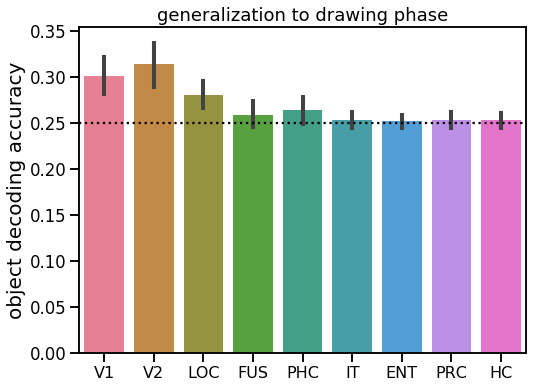

In [30]:
## plot test accuracy on drawing runs; trained on recognition runs
from matplotlib import rc
hfont = {'fontname':'Helvetica'}
if 'Acc' in locals():
    Acc = np.array(Acc)
    x = pd.DataFrame(Acc.transpose())
    x.columns = roi_list_recog
    
    sns.set_context('talk')
    fig = plt.figure(figsize=(8,6))
    fig = sns.barplot(data=x,palette='husl',ci=95)
    chance_dict = {'4way':0.25,'3way':0.33,'2way':0.5}
    plt.axhline(chance_dict[version],linestyle=':',color='k')
    plt.ylabel('object decoding accuracy',fontsize=20, **hfont)
    plt.title('generalization to drawing phase', **hfont)
    fig.set_xticklabels(h.roi_list_recog_formatted,fontsize=16, **hfont)
    out_path = os.path.join(proj_dir,'plots/{}/draw_decoding_accuracy.pdf'.format(nb_name))
    plt.savefig(out_path,format='pdf')

### make summary timecourse plots

In [ ]:
reload(h)
versions = ['2way','3way','4way', '4wayIndependent']
tags = ['logged', 'raw']
csvname = 'logistic_timeseries_drawing_neural_{}_{}.csv'

reallyRun = 0
if reallyRun:
    for version in versions:
        for tag in tags:
            ALLDM = pd.read_csv(
                os.path.join(results_dir, csvname.format(version,tag)))
            try:
                h.plot_summary_timecourse(ALLDM,
                                        this_iv='trial_num',
                                        roi_list=roi_list_recog,
                                        render_cond=1,
                                        version = version,
                                        proj_dir=proj_dir)
            except KeyError:
                pass

In [ ]:
vgg_mode = 0
if vgg_mode:
    vgg_tag = 'raw'
    baseline_correct = True
    bc = 'basecorr' if baseline_correct else ''
    VGG = pd.read_csv(str(results_dir)+'VGG_{}_{}.csv'.format(vgg_tag, bc))

    h.plot_summary_timecourse(VGG,
                            this_iv='trial_num',
                            roi_list=['VGG'],
                            render_cond=1,
                            baseline_correct = True,
                            version = version,
                            proj_dir=proj_dir)

#### get subject-level index of contrast between objects during drawing


In [ ]:
lookup = dict(zip(['trial_num','run_num','time_point'],['repetition','run','TR']))
version = '4way'
tag = 'logged'
ALLDM = pd.read_csv('{}/csv/logistic_timeseries_drawing_neural_{}_{}.csv'.format(proj_dir,version,tag))
ALLDM = h.cleanup_df(ALLDM)
# VGG = pd.read_csv(os.path.join(results_dir,'partial_sketch_full.csv'))

In [ ]:
reload(h)
this_iv = 'trial_num' ## other options 'run_num','trial_num','time_point'
version = '4way'

d = h.get_log_odds(ALLDM,
               this_iv = this_iv,
               roi_list = roi_list_recog,
               version=version,
               logged=True,
               proj_dir=proj_dir)

In [ ]:
run_this = 1
if run_this:
    ## comparing 4-way and 2-way probability ratios
    d4way = pd.read_csv(os.path.join(proj_dir,'csv', 'difference_logprobs_4way.csv'))
    d2way = pd.read_csv(os.path.join(proj_dir,'csv', 'difference_logprobs_2way.csv'))
    inds = d4way['roi']=='V1'
    plt.scatter(d4way[inds]['target-foil'],d2way[inds]['target-foil'])

In [ ]:
conditions = ['target-foil','target-control','foil-control']
for condition in conditions:
    print('------- condition: {} -------'.format(condition))
    for this_roi in roi_list_recog:
        data = d[d['roi']==this_roi][condition].values
        U,lb,ub,p1,p2 = h.bootstrapCI(data,3000)
        print('ROI = {} | mean = {}  95% CI: [{} {}] p(x<0)={} p(x>0)={}'.format(
            this_roi,np.round(U,5),np.round(lb,3),np.round(ub,5),np.round(p1,5),np.round(p2,5)))

### How do individual differences in object evidence relate to individual differences in pre-post differentiation across ROIs?

In [ ]:
version = '4way'
tag = 'log'
d = pd.read_csv(os.path.join(proj_dir,'csv/difference_{}probs_{}.csv'.format(tag,version)))
prepost = pd.read_csv(os.path.join(proj_dir,'csv/neural_changes_by_surfroi_and_subject.csv'))

In [ ]:
## make dataframe to relate drawing contrast to recognition differentiation
roi_list = ['V1', 'V2', 'LOC', 'IT', 'fusiform', 'parahippo', 'PRC', 'ento','hipp', 'mOFC']

for this_roi in roi_list:
    draw = d[d['roi']==this_roi]['target-foil'].values
    recog = prepost['UnanchoredTrainedDiff_{}'.format(this_roi)].values-prepost['UnanchoredControlDiff_{}'.format(this_roi)].values

    z = pd.DataFrame([draw,recog])
    z = z.transpose()
    z.columns=['draw','recog']

    ## plot 
    fig = plt.figure(figsize=(6,6))
    sns.set_context('poster')
    sns.regplot(x="draw",
                y ="recog",
                data=z)
    r,p = stats.pearsonr(draw,recog)
    plt.title('ROI: {}  r={}  p={}'.format(this_roi,np.round(r,5),np.round(p,5)))
    if np.round(p,5)<0.05:
        accent = '*'
    else:
        accent = ''
    print('ROI: {} r={}  p={} {}'.format(this_roi,np.round(r,5),np.round(p,5),accent))
    plt.xlabel('drawing: target vs. foil contrast') 
    plt.ylabel('recog: post-pre differentiation')
    if not os.path.exists(os.path.join(proj_dir,'plots/{}/drawrecog'.format(nb_name))):
        os.makedirs(os.path.join(proj_dir,'plots/{}/drawrecog'.format(nb_name)))
    plt.tight_layout()
    plt.savefig(os.path.join(proj_dir,'plots/{}/drawrecog/draw_recog_scatter_{}.png'.format(nb_name,this_roi)))
    plt.close(fig)

### How are individual differences in object evidence related between ROIs? 

In [ ]:
### jgunn will add correlation matrices here